<a href="https://colab.research.google.com/github/spe301/dsc-phase-4-project/blob/main/Phase_4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#Data loading for csv and txt files
from google.colab import files
path_to_file = list(files.upload().keys())[0]

Saving judge-1377884607_tweet_product_company.csv to judge-1377884607_tweet_product_company (1).csv


In [17]:
import pandas as pd

df = pd.read_csv('judge-1377884607_tweet_product_company (1).csv', engine='python')

In [18]:
#dropping row 6 as there's no tweet in that row and dropping all rows where sentiment is "I can't tell"
df = df.drop(6)
df = df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [19]:
#stripping punctuation
ix = list(df.index)
clean = []
for i in range(len(ix)):
  clean.append(df['tweet_text'][ix[i]].replace('.@', '').replace('.', '').replace('!', '').replace('@', '').replace('?', '').replace(':', '')
  .replace(',', '').replace(';', '').lower())

df['tweet'] = clean

These are a some classes of helper functions that will make modeling and eda more efficient.

- Data Helper: data preprocessing
  - MulticlassOutput: output preprocessing
  - ModelReadyText1: converts tweets into tokenized sequences
  - ModelReadyText2: converts tweets into  one-hot-encoded vectors
  - ViewAccuracy: plots a model's accuracy throughout training
  - ViewLoss: plots a model's accuracy throughout training

- Deep Learning: model building and testing 
  - Powers: help the model building functions determine nlayers
  - Sparsity: help the model building function know when to use 'sparse_categorical_crossentropy' as loss function
  - FeedForward: builds a simple neural net with only Dense Layers
  - RNN: builds a neural network with LSTM or GRU layer(s)
  - TestDL: wraps the keras wrapper functions and GridSearchCV into a simple one liner, one line plus the parameter grid that is :)


In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from math import log
from keras.regularizers import  L2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

class DataHelper:

  def MulticlassOutput(self, df, col):
    enc = OneHotEncoder()
    y = np.array(df[col]).reshape(-1, 1)
    oh = enc.fit_transform(y).toarray()
    return oh


  def ModelReadyText1(self, df, Xcol, ycol, pad):
    text = list(df[Xcol])
    t = Tokenizer()
    t.fit_on_texts(text)
    tokens = t.texts_to_sequences(text)
    tokens2 = pad_sequences(tokens, maxlen=pad)
    dh = DataHelper()
    y = dh.MulticlassOutput(df, ycol)
    return tokens2, y

  def ModelReadyText2(self, df, Xcol, ycol, num_words):
    dh = DataHelper()
    text = list(df[Xcol])
    t = Tokenizer(num_words=num_words)
    t.fit_on_texts(text)
    oh = t.texts_to_matrix(text)
    y = dh.MulticlassOutput(df, ycol)
    return oh, y

  def ViewAccuracy(self, history, epochs):
    plt.plot(range(epochs), history.history['accuracy'], label='train');
    plt.plot(range(epochs), history.history['val_accuracy'], label='val');
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    return None


  def ViewLoss(self, history, epochs):
      plt.plot(range(epochs), history.history['loss'], label='train');
      plt.plot(range(epochs), history.history['val_loss'], label='val');
      plt.legend(loc='best')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      return None

class DeepLearning:

  def Powers(self, n):
    k = int(log(n, 2))
    return k

  def Sparsity(self, x):
    df = pd.DataFrame(x[0])
    df.columns = ['val']
    df2 = df.loc[df['val'] == 0]
    return len(df)*0.9 <= len(df2)

  def FeedForward(self, nodes, activation, optimizer, dropout, regularizer, inp, nclasses):
    dl = DeepLearning()
    if nclasses > 16:
      pen = nclasses*2
    else:
      pen = 16
    if nclasses == 2:
      oa = 'sigmoid'
      loss = 'binary_crossentropy'
    else:
      oa = 'softmax'
      if dl.Sparsity(X) == False:
        loss = 'categorical_crossentropy'
      else:
        loss = 'sparse_categorical_crossentropy'
    model = models.Sequential()
    if regularizer == None:
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,)))
    if regularizer == 'L1':
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,), kernel_regularizer=l1(0.005)))
    if regularizer == 'L2':
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,), kernel_regularizer=L2(0.005)))
    if dropout == True:
      model.add(layers.Dropout(0.5))
    p = dl.Powers(nodes)
    for i in range(p):
      nodes /= 2
      nodes = int(nodes)
      if nodes > 16:
        if nodes > nclasses:
          model.add(layers.Dense(nodes, activation=activation))
    model.add(layers.Dense(pen, activation=activation))
    model.add(layers.Dense(nclasses, activation=oa))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

  def RNN(self, nodes, activation, optimizer, dropout, regularizer, method, stacking, inp, nclasses):
    dl = DeepLearning()
    if nclasses > 16:
      pen = nclasses*2
    else:
      pen = 16
    if nclasses == 2:
      oa = 'sigmoid'
      loss = 'binary_crossentropy'
    else:
      oa = 'softmax'
      if dl.Sparsity(X) == False:
        loss = 'categorical_crossentropy'
      else:
        loss = 'sparse_categorical_crossentropy'  
    model = models.Sequential()
    model.add(layers.Embedding(inp, nodes))
    if method == 'LSTM':
      if regularizer == None:
        model.add(layers.LSTM(nodes, activation=activation, return_sequences=stacking))
      if regularizer == 'L1':
        model.add(layers.LSTM(nodes, activation=activation, kernel_regularizer=l1(0.005), return_sequences=stacking))
      if regularizer == 'L2':
        model.add(layers.LSTM(nodes, activation=activation, kernel_regularizer=L2(0.005), return_sequences=stacking))
    if method == 'GRU':
      if regularizer == None:
        model.add(layers.GRU(nodes, activation=activation, return_sequences=stacking))
      if regularizer == 'L1':
        model.add(layers.GRU(nodes, activation=activation, kernel_regularizer=l1(0.005), return_sequences=stacking))
      if regularizer == 'L2':
        model.add(layers.GRU(nodes, activation=activation, kernel_regularizer=L2(0.005), return_sequences=stacking))
    if dropout == True:
      model.add(layers.Dropout(0.5))
    dl = DeepLearning()
    if stacking == True:
      nodes = nodes//2
      if method == 'LSTM':
        model.add(layers.LSTM(nodes, activation=activation))
      else:
        model.add(layers.GRU(nodes, activation=activation))
    p = dl.Powers(nodes)
    for i in range(p):
      nodes /= 2
      nodes = int(nodes)
      if nodes > 16:
        if nodes > nclasses:
          model.add(layers.Dense(nodes, activation=activation))
    model.add(layers.Dense(pen, activation=activation))
    model.add(layers.Dense(nclasses, activation=oa))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

  def TestDL(self, params, func, task, X, y, X_val=None, y_val=None, batch_size=64, epochs=50):
    early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]
    if task == 'classification':
      k = KerasClassifier(func)
    if task == 'regression':
      k = KerasRegressor(func)
    grid = GridSearchCV(k, params, cv=3)
    if type(X_val) != np.ndarray:
      grid.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    else:
      grid.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=early_stopping)
    return grid

In [21]:
dh = DataHelper()
dl = DeepLearning()
X, y = dh.ModelReadyText1(df, 'tweet', 'is_there_an_emotion_directed_at_a_brand_or_product', pad=33)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [22]:
def Bidirectional(vocab, nodes, output, optimizer, metrics, activation):
  if output == 1:
    oa = 'linear'
    loss = 'mse'
  if output == 2:
    oa = 'sigmoid'
    loss = 'binary_crossentropy'
  else:
    oa = 'softmax'
    loss = 'categorical_crossentropy'
  model = models.Sequential()
  model.add(layers.Embedding(vocab, nodes)) 
  model.add(layers.Bidirectional(layers.LSTM(nodes))) 
  model.add(layers.Dense(nodes/2, activation=activation))
  model.add(layers.Dense(nodes/4, activation=activation))
  model.add(layers.Dense(output, activation=oa))
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

B = Bidirectional(12500, 64, 3, 'adam', ['accuracy'], 'relu')
early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]
B.summary()
B.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=early_stopping, validation_split=0.2)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_51 (Embedding)     (None, None, 64)          800000    
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_153 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_154 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_155 (Dense)            (None, 3)                 51        
Total params: 870,755
Trainable params: 870,755
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
101/101 [==============================] - 2s 22ms/step - loss: 0.8574 - accuracy: 0.6050 - val_loss: 

In [23]:
params = {'nodes': [50, 64, 128, 256], 'activation': ['relu', 'tanh'], 'optimizer': ['rmsprop', 'adam'], 'metrics': ['accuracy'], 'vocab': [12500], 'output': [3]}

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.2)
grid = dl.TestDL(params, Bidirectional, 'classification', X_train, y_train, X_val=X_val, y_val=y_val)

Epoch 1/50
84/84 [==============================] - 2s 20ms/step - loss: 0.8418 - accuracy: 0.6025 - val_loss: 0.7808 - val_accuracy: 0.6147
Epoch 2/50
84/84 [==============================] - 1s 13ms/step - loss: 0.7307 - accuracy: 0.6736 - val_loss: 0.6951 - val_accuracy: 0.6861
Epoch 3/50
84/84 [==============================] - 1s 13ms/step - loss: 0.6344 - accuracy: 0.7249 - val_loss: 0.6487 - val_accuracy: 0.7004
Epoch 4/50
84/84 [==============================] - 1s 13ms/step - loss: 0.5433 - accuracy: 0.7788 - val_loss: 0.5575 - val_accuracy: 0.7676
Epoch 5/50
84/84 [==============================] - 1s 13ms/step - loss: 0.4566 - accuracy: 0.8213 - val_loss: 0.5051 - val_accuracy: 0.8030
Epoch 6/50
84/84 [==============================] - 1s 14ms/step - loss: 0.4001 - accuracy: 0.8394 - val_loss: 0.4664 - val_accuracy: 0.8247
Epoch 7/50
84/84 [==============================] - 1s 13ms/step - loss: 0.3514 - accuracy: 0.8679 - val_loss: 0.4987 - val_accuracy: 0.8297
Epoch 8/50
84

In [28]:
grid.best_estimator_.model.save('model.h5')

In [29]:
model = models.load_model('model.h5')

In [30]:
model.evaluate(X_test, y_test, batch_size=64)

14/14 [==============================] - 0s 6ms/step - loss: 3.2004 - accuracy: 0.6376


[3.2004151344299316, 0.6375839114189148]

In [31]:
model.evaluate(X_train, y_train, batch_size=64)

126/126 [==============================] - 1s 5ms/step - loss: 0.0216 - accuracy: 0.9896


[0.021602975204586983, 0.9895548224449158]

In [34]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0271 - accuracy: 0.9894 - val_loss: 0.0326 - val_accuracy: 0.9863
Epoch 2/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0280 - accuracy: 0.9887 - val_loss: 0.0695 - val_accuracy: 0.9770
Epoch 3/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0305 - accuracy: 0.9882 - val_loss: 0.0673 - val_accuracy: 0.9770
Epoch 4/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0290 - accuracy: 0.9887 - val_loss: 0.0684 - val_accuracy: 0.9733
Epoch 5/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0232 - accuracy: 0.9904 - val_loss: 0.0624 - val_accuracy: 0.9782
Epoch 6/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0168 - accuracy: 0.9924 - val_loss: 0.0573 - val_accuracy: 0.9776
Epoch 7/50
101/101 [==============================] - 2s 25ms/step - loss: 0.0175 - accuracy: 0.9913 - val_loss: 0.0696 - val_accuracy: 0.9714

It is important to keep in mind that these histories ar showing the results of a model that was already trained.

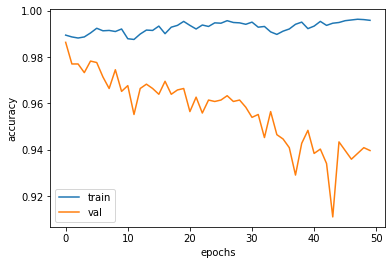

In [35]:
dh.ViewAccuracy(history, 50)

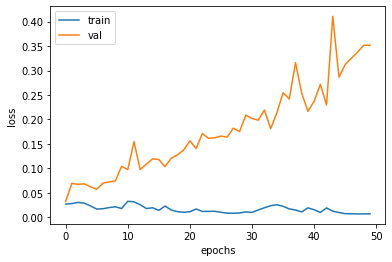

In [36]:
dh.ViewLoss(history, 50)

I was planning on doing another gridsearch on my RNN building function to test out LSTM's and GRU's of varying sizes. However I'm going to do something about class imbalances first. Although I deleted these cells for some reason, I realized that the only way to stop the model from overfitting was to use l1 regularization. However, train and validation accuracy just stay around 60% which is interesting because ~60% of the data is of one class.

In [37]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

I went back into my network building functions to parameritize metrics. if you look at the code it's already fixed but just note that accuracy was originally hardcoded as the metric for the models.

In [38]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',
                                np.unique(df['is_there_an_emotion_directed_at_a_brand_or_product']),
                                df['is_there_an_emotion_directed_at_a_brand_or_product'])

weights_dict = dict(zip(range(3), weights))
weights_dict

{0: 5.2257309941520464, 1: 0.5528334570650829, 2: 1.0002238638907543}

In [39]:
grid.best_params_

{'activation': 'relu',
 'metrics': 'accuracy',
 'nodes': 128,
 'optimizer': 'adam',
 'output': 3,
 'vocab': 12500}

In [40]:
from keras.metrics import Recall, Precision

model2 = models.Sequential()
model2.add(layers.Embedding(12500, 128))
model2.add(layers.Bidirectional(layers.LSTM(128)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=early_stopping, class_weight=weights_dict)

Epoch 1/50
101/101 [==============================] - 4s 35ms/step - loss: 1.0471 - accuracy: 0.5010 - val_loss: 0.9144 - val_accuracy: 0.5177
Epoch 2/50
101/101 [==============================] - 3s 26ms/step - loss: 0.7853 - accuracy: 0.5613 - val_loss: 0.9364 - val_accuracy: 0.5208
Epoch 3/50
101/101 [==============================] - 3s 26ms/step - loss: 0.5038 - accuracy: 0.7116 - val_loss: 1.0208 - val_accuracy: 0.5420
Epoch 4/50
101/101 [==============================] - 3s 26ms/step - loss: 0.3306 - accuracy: 0.8279 - val_loss: 0.8249 - val_accuracy: 0.6551
Epoch 5/50
101/101 [==============================] - 3s 26ms/step - loss: 0.2449 - accuracy: 0.8672 - val_loss: 0.9706 - val_accuracy: 0.6358
Epoch 6/50
101/101 [==============================] - 3s 26ms/step - loss: 0.1958 - accuracy: 0.8945 - val_loss: 0.9900 - val_accuracy: 0.6476
Epoch 7/50
101/101 [==============================] - 3s 26ms/step - loss: 0.1779 - accuracy: 0.9050 - val_loss: 1.1221 - val_accuracy: 0.6234

Interesting, The model actually did worse!

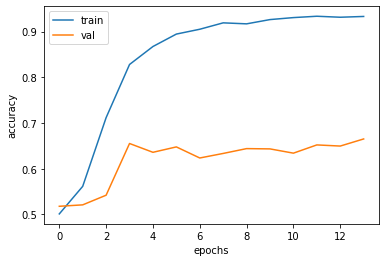

In [41]:
dh.ViewAccuracy(history, 14)

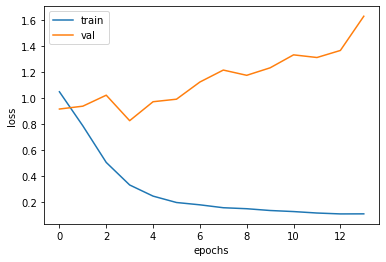

In [42]:
dh.ViewLoss(history, 14)

I would do an exaustive gridsearch on my RNN building function to test out LSTM's and GRU's of varying parameters and sizes. however fixing class imbalances didn't help and I don't want to waste compute. I will instead use glove embeddings rather than creating my own embedding layer. I will also try a traditional machine learning approach later on.

In [43]:
tokens = []
for num in ix:
  tokens.append(df['tweet'][num].split(' '))

In [44]:
from gensim.models import Word2Vec, keyedvectors

W = Word2Vec(tokens, size=33, window=3, min_count=1, workers=4)
W.train(sentences=tokens, total_examples=W.corpus_count, epochs=10)
wv = W.wv

In [45]:
e = W.wv.get_keras_embedding(train_embeddings=False)

In [46]:
from keras.metrics import Recall #the model did better with accuracy in my experiance but feel free to try with recall or precision
from keras.metrics import  Precision

model3 = models.Sequential()
model3.add(e)
model3.add(layers.Bidirectional(layers.LSTM(128)))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]

history = model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=early_stopping, class_weight=weights_dict)

Epoch 1/50
101/101 [==============================] - 2s 17ms/step - loss: 1.0679 - accuracy: 0.3973 - val_loss: 1.0697 - val_accuracy: 0.3754
Epoch 2/50
101/101 [==============================] - 1s 10ms/step - loss: 1.0365 - accuracy: 0.4113 - val_loss: 1.0212 - val_accuracy: 0.4177
Epoch 3/50
101/101 [==============================] - 1s 10ms/step - loss: 1.0094 - accuracy: 0.4301 - val_loss: 1.0059 - val_accuracy: 0.4444
Epoch 4/50
101/101 [==============================] - 1s 10ms/step - loss: 0.9811 - accuracy: 0.4570 - val_loss: 1.0144 - val_accuracy: 0.4400
Epoch 5/50
101/101 [==============================] - 1s 10ms/step - loss: 0.9508 - accuracy: 0.4642 - val_loss: 1.1115 - val_accuracy: 0.3835
Epoch 6/50
101/101 [==============================] - 1s 10ms/step - loss: 0.9259 - accuracy: 0.4786 - val_loss: 1.0403 - val_accuracy: 0.4195
Epoch 7/50
101/101 [==============================] - 1s 10ms/step - loss: 0.8933 - accuracy: 0.4931 - val_loss: 0.9133 - val_accuracy: 0.5277

This model was trained on the word embeddings created by Gensim rather than the one I made. The model preformed poorly but in it's defense it did start with a lower accuracy in the mid 30's.

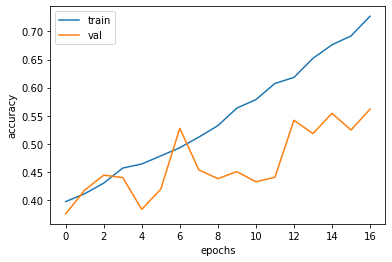

In [47]:
dh.ViewAccuracy(history, 17)

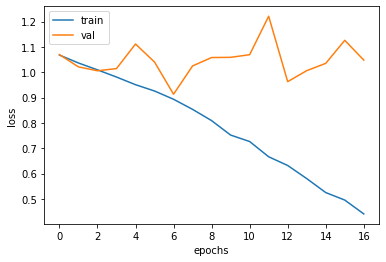

In [48]:
dh.ViewLoss(history, 17)

In [55]:
import nltk
nltk.download('stopwords')
stopwords_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
# feel free to play around with the most_similar() method that returns words most or least similar to the selected word
# for most similar use 'positive=', for least similar use 'negative='
wv.most_similar(positive='google')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[("google's", 0.7707618474960327),
 ('#google', 0.7331227660179138),
 ('discusses', 0.723946213722229),
 ('3-d', 0.7074164152145386),
 ('coworker', 0.7063686847686768),
 ('&quotgoogle', 0.7004574537277222),
 ("#google's", 0.6989423632621765),
 ('anatomy', 0.6980515122413635),
 ('upbeat', 0.6945469975471497),
 ('offline', 0.6936755180358887)]

Trying a different approach! I one hot encoded each tweet for all of the words in the corpus. I will use PCA to compress the very sparse data

In [56]:
X_oh, y_oh = dh.ModelReadyText2(df, 'tweet', 'is_there_an_emotion_directed_at_a_brand_or_product', 12500)

In [57]:
classes = []
for arr in y_oh:
  classes.append(arr.argmax())

In [58]:
df2 = pd.DataFrame(X_oh)
df2['target'] = classes
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12461,12462,12463,12464,12465,12466,12467,12468,12469,12470,12471,12472,12473,12474,12475,12476,12477,12478,12479,12480,12481,12482,12483,12484,12485,12486,12487,12488,12489,12490,12491,12492,12493,12494,12495,12496,12497,12498,12499,target
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
8932,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8934,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=290)

X = df2.drop(['target'], axis='columns')

df3 = pd.DataFrame(pca.fit_transform(X))

In [60]:
df3['target'] = classes

In [61]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor

class MachineLearning:
    
    def CompareClassifiers(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        if n == 2:
            methods = [KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                      AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), LogisticRegression(),
                      SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'Log', 'SVM']
        else:
            methods = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]
            strs = ['KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            clf = methods[i].fit(X_train, y_train)
            train_acc.append(clf.score(X_train, y_train))
            test_acc.append(clf.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def CompareRegressors(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        methods = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),
                       AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), SVR()]
        strs = ['Lin', 'KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            reg = methods[i].fit(X_train, y_train)
            train_acc.append(reg.score(X_train, y_train))
            test_acc.append(reg.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def Optimize(self, model, parameters, X, y, metric='accuracy'):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            return GridSearchCV(model, parameters, cv=5, scoring=metric, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        except:
            return GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        
    def PipeIt(self, scaler, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        pipe = Pipeline([('scaler', scaler), ('model', model)]).fit(X_train, y_train)
        return "Training: {}, Validation: {}".format(pipe.score(X_train, y_train), pipe.score(X_test, y_test))


class DataAssist:
    
    def ScaleData(self, strategy, y_var, data):
        X = data.drop([y_var], axis='columns')
        if strategy == 'minmax':
            return MinMaxScaler().fit(X).transform(X)
        if strategy == 'standard':
            return StandardScaler().fit(X).transform(X)
        if strategy == 'mean':
            for col in X.columns:
                X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col]))
            return X
        
    def HoldOut(self, data):
        train, test = train_test_split(data, test_size=0.1)
        return train, test
    
    def MakeNewDF(self, X, y, k):
        selector = SelectKBest(k=k).fit(X, y)
        mask = selector.get_support()
        selected = []
        for i in range(len(mask)):
            if mask[i] == True:
                selected.append(X.columns[i])
        df = pd.DataFrame(selector.transform(X))
        df.columns = selected
        return df
    
    def VifIt(self, X):
        vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
        return vif
        
    
class Evaluater:
    
    def ScoreModel(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        algo = model.fit(X_train, y_train)
        return 'Training: {}, Validation: {}'.format(algo.score(X_train, y_train), algo.score(X_test, y_test))
    
    def BuildConfusion(self, fitted_model,  Xval, yval, cmap='plasma'):
        cm = plot_confusion_matrix(fitted_model, Xval, yval, cmap=cmap)
        return cm
    
    def BuildTree(self, tree):
        try:
            return plot_tree(tree)
        except:
            return 'Please pass a tree class'
    
    def GetCoefficients(self, model, X, y):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            model.fit(X_train, y_train)
            return 'coefficients: {}'.format(model.coef_)
        except:
            return 'Please pass LinearRegression, LogisticRegression, or an SVM with a linear kernel'
        
    def GetImportance(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        model.fit(X_train, y_train)
        try:
            FI = model.feature_importances_
            n_features = X_train.shape[1]
            plt.figure(figsize=(8,8))
            plt.barh(range(n_features), FI, align='center') 
            plt.yticks(np.arange(n_features), X_train.columns.values) 
            plt.xlabel('Feature importance')
            plt.ylabel('Feature')
        except:
            return 'Please pass an ensemble class'
        
    def AUC(self, model, Xval, yval):
        pred = model.predict(Xval)
        fpr, tpr, threshold = roc_curve(yval, pred)
        return auc(fpr, tpr)
    
ml = MachineLearning()
da = DataAssist()
ev = Evaluater()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [62]:
X_train = da.HoldOut(df3)[0].drop(['target'], axis='columns')
y_train = da.HoldOut(df3)[0]['target']
X_test = da.HoldOut(df3)[1].drop(['target'], axis='columns')
y_test = da.HoldOut(df3)[1]['target']

In [63]:
model4 = XGBClassifier()

model4.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [64]:
model4.score(X_test, y_test)

0.5805369127516778

In [65]:
model4.score(X_train, y_train)

0.6415070877891071

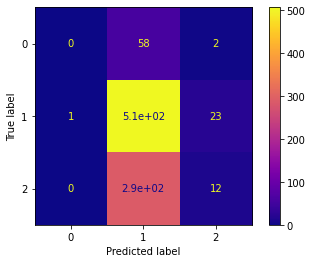

In [66]:
ev.BuildConfusion(model4, X_test, y_test)

using Smote, synthetic minority oversampling, to fix class imbalance issues. As it lables everything as neutral.

In [67]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [68]:
xgb = XGBClassifier()
xgb.fit(X_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [69]:
xgb.score(X_res, y_res)

0.7191498142798184

In [70]:
xgb.score(np.array(X_test), np.array(y_test))

0.44966442953020136

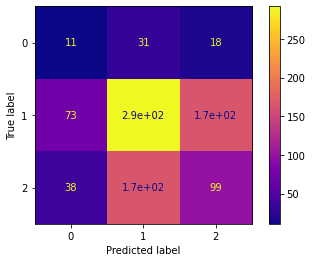

In [72]:
ev.BuildConfusion(xgb, np.array(X_test), np.array(y_test))

After trying various RNN's and gradient boosted forests trained on word embeddings, and trained on a PCA transformed one hot encoded vectors. I've concluded that the RNN saved as 'bid.h5' was the best. Although it was overfit it got 94% accuracy. I will now access random tweets outside of the dataset via the twitter API and see how the model classifies the tweets

In [73]:
from google.colab import files
path_to_file = list(files.upload().keys())[0]

Saving ssh-twitter.txt to ssh-twitter.txt


In [74]:
import tweepy

c1 = open('ssh-twitter.txt').readlines()[2].split(':')[1].replace('\n', '').replace(' ', '')
c2 = open('ssh-twitter.txt').readlines()[3].split(':')[1].replace('\n', '').replace(' ', '')
a1 = open('ssh-twitter.txt').readlines()[0].split(':')[1].replace('\n', '').replace(' ', '')
a2 = open('ssh-twitter.txt').readlines()[1].split(':')[1].replace('\n', '').replace(' ', '')

auth = tweepy.OAuthHandler(c1, c2)
auth.set_access_token(a1, a2)

def GetTweets(Topic):
  api = tweepy.API(auth)
  topic = api.search(Topic)
  tweets = []
  time = []
  for i in range(len(topic)):
    tweets.append(topic[i]._json['text'].replace('\n', '').replace('.@', '').replace('.', '').replace('!', '').replace('@', '')
    .replace('?', '').replace(':', '').replace(',', '').replace(';', '').lower())
    time.append(topic[i]._json['created_at'])
    res = pd.DataFrame(tweets)
  res.columns = ['text']
  res['time'] = time 
  X = dh.ModelReadyText1(res, 'text', 'time', 33)[0]
  backup_dim = len(X), len(res)
  sent = []
  for arr in X:
    sentiment = int(round(model.predict(arr).argmax()/len(arr)-1))
    if sentiment == 0:
      sent.append('Negative')
    if sentiment == 1:
      sent.append('Neutral')
    if sentiment == 2:
      sent.append('Positive')
  res['sentiment'] = sent 
  results = res.drop(['time'], axis='columns')
  return results

With this GetTweets function all you have to do is enter a topic and you'll get a dataframe with tweets selected by the tweepy module and the sentiment that the model predicts!

In [76]:
GetTweets('google')

,text,sentiment
0,jaebubblyjae ok google cara menjadi matetsu di...,Neutral
1,rt esquerdaexposta celebração cristã do google...,Neutral
2,rt jjkgif https//tco/2bzilc9ttt#정국 #jungkook #...,Neutral
3,rt vavaxxsyster [แจกคนรีทวิต] แจกโปสการ์ดx'mas...,Neutral
4,rt daphne_dsch j’ai mute ce tweet y’a environ ...,Neutral
5,🔵 🔴 así evitas que google maps te pida valorar...,Positive
6,rt mybabykim97 𝗽𝗹𝘀 𝗥𝗧 สุ่มแจก2ชิ้นรายได้หลังหั...,Neutral
7,sa_da_tay monsters inc but it's a bunch of fuc...,Negative
8,pmoindia pm sir please humble request you sir ...,Neutral
9,rt bp_votingteam 📣[30th high1 seoul music awar...,Neutral


In [77]:
model.summary()

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_100 (Embedding)    (None, None, 128)         1600000   
_________________________________________________________________
bidirectional_100 (Bidirecti (None, 256)               263168    
_________________________________________________________________
dense_300 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_301 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_302 (Dense)            (None, 3)                 99        
Total params: 1,881,795
Trainable params: 1,881,795
Non-trainable params: 0
_________________________________________________________________


EDA Questions...
1. according to the model how do the sentiment percentage breakdowns for ipad and iphone compare?
2. what are the top 5 most common words for tweets of negative, positive, and neutral sentiment?
3. how long is the average tweet of each sentiment?
4. what are the most used hashtags throughout the dataset?

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


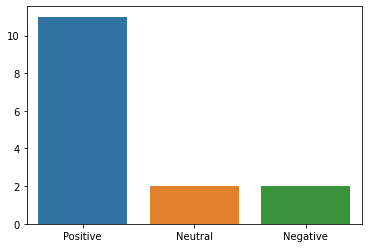

In [82]:
import seaborn as sns

X = GetTweets('ipad')
y = ['Positive', 'Neutral', 'Negative']
pos = len(X.loc[X['sentiment'] == 'Positive'])
neu = len(X.loc[X['sentiment'] == 'Neutral'])
neg = len(X.loc[X['sentiment'] == 'Negative'])

sns.barplot(y, [pos, neu, neg]);
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


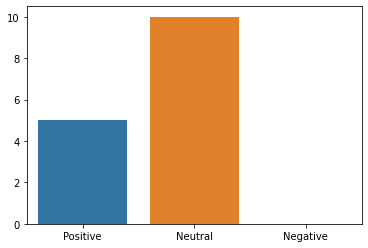

In [ ]:
X = GetTweets('iphone')
y = ['Positive', 'Neutral', 'Negative']
pos = len(X.loc[X['sentiment'] == 'Positive'])
neu = len(X.loc[X['sentiment'] == 'Neutral'])
neg = len(X.loc[X['sentiment'] == 'Negative'])

sns.barplot(y, [pos, neu, neg]);
plt.show()

Question 1: The iphone tweets were all labled as neutral or positive whereas some ipad tweets were labled as negative.

In [83]:
def Top5(df, X, yvar, y, stopwords_list=stopwords_list):
  stopwords_list = stopwords_list + ['mention', 'link', 'it', '-', ':)', '', 'it']
  data = df.loc[df[yvar] == y]
  ix = list(data.index)
  corpus = []
  for num in ix:
    tweet = list(data[X][num].split(' '))
    corpus += tweet
  final = []
  for word in corpus:
    if not word in stopwords_list:
      Word = word.lower().replace('@', '').replace('{', '').replace('}', '').replace('.', '').replace('!', '').replace("'", "")
      if Word not in stopwords_list:
        final.append(Word)
  res = pd.Series(final)
  counts = pd.DataFrame(res.value_counts()[:5])
  counts.columns = ['num']
  count = []
  words = list(counts.index)
  for i in range(5):
    count.append(counts['num'][i])
  return sns.barplot(words, count, palette='plasma');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


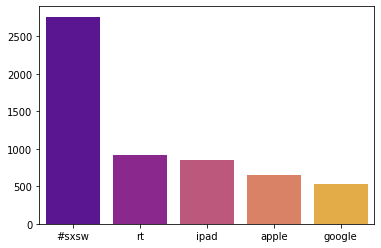

In [84]:
Top5(df, 'tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'Positive emotion')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


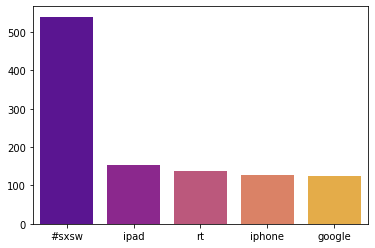

In [85]:
Top5(df, 'tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'Negative emotion')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


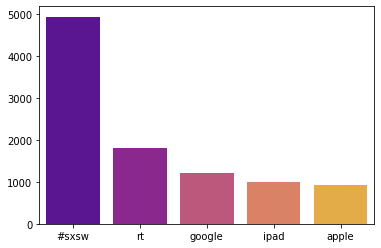

In [86]:
Top5(df, 'tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'No emotion toward brand or product')

Question 2: #sxsw was a very popular term throughout the dataset, among them google, apple, and ipad were very popular words.

In [87]:
def GetLengths(df, X, yvar, y):
  data = df.loc[df[yvar] == y]
  lens = []
  ix = list(data.index)
  for num in ix:
    tweet = list(data[X][num].split(' '))
    lens.append(len(tweet))
  return int(np.mean(lens))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


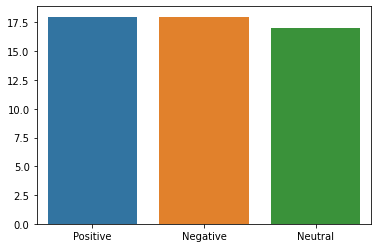

In [88]:
pos = GetLengths(df, 'tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'Positive emotion')
neg = GetLengths(df, 'tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'Negative emotion')
neu = GetLengths(df, 'tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'No emotion toward brand or product')
x = ['Positive', 'Negative', 'Neutral']
y = [pos, neg, neu]
sns.barplot(x, y);

Question3: The Tweets remain about 18-20 characters long regardless of sentiment.

In [92]:
def Hashtags(df, X):
  tweets = []
  ix = list(df.index)
  for num in ix: 
    text = df[X][num].split(' ')
    tweets += text
  hashtags = []
  words = []
  for word in tweets:
    words.append(word.lower().replace('?', '').replace('.', '').replace(',', '').replace(':', '').replace('!', ''))
  for word in words:
    if word.startswith('#'):
      hashtags.append(word)
  ht = pd.Series(hashtags)
  counts = pd.DataFrame(ht.value_counts())
  counts.columns = ['num']
  return counts

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


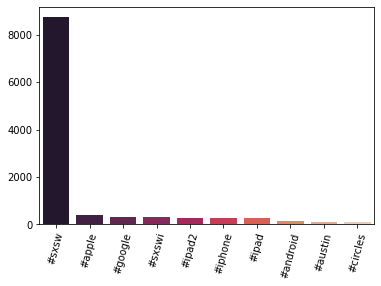

In [93]:
import matplotlib.pyplot as plt

X = Hashtags(df, 'tweet_text')[:10]
x = list(X.index)
y = list(X['num'])
sns.barplot(x, y, palette='rocket');
plt.xticks(rotation=75)
plt.show()

'#sxsw' and it's variants; '#sxsw!', '#sxsw?', '#sxsw.', and '#sxsw:', was by far the most popular hashtag and it was used over 8,000 times throughout the dataset. most of the other hashtags refered to tech companies and tech products. '#austin' was also popular as the sxsw film festival is hosted in Austin, TX.

In [94]:
GetTweets('Covid')

,text,sentiment
0,rt carl0smoreno mientras ayuso despilfarra mil...,Neutral
1,"""the british-swedish company astrazeneca has a...",Negative
2,rt clarecraigpath there are fewer a&ampe atten...,Negative
3,rt torontopfr leisure skate is offered at city...,Neutral
4,rt falican check on your archaeology friends d...,Neutral
5,rt studentsfordemo realdonaldtrump globally 22...,Negative
6,sammythesecond typical behaviour if one stands...,Neutral
7,mcconnell rejects bipartisan covid relief plan...,Neutral
8,now trump knew of covid danger but downplayed ...,Neutral
9,i_m_agust_d i’m close assuming this isn’t some...,Negative
